## Imports

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [3]:
# Pretty plots
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [78]:
from src.models import Model, LinearModel
from src.oadam import OAdam, add_weight_decay, net_to_list
from src.learners.bc import BC
from src.learners.doubil import DoubIL
from src.learners.residuil import ResiduIL

## LQG System

In [4]:
import src.lqg

In [5]:
K_star = src.lqg.solve(src.lqg.A, src.lqg.B, src.lqg.Q, src.lqg.R)
print(K_star)
def expert(s):
    if s.size == 2:
        return K_star @ s
    else:
        return s @ K_star.T

Converged with horizon 34
[[-2.57543063 -3.43994714]]


In [6]:
denoised_expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.rollout(s_0, expert)
    denoised_expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

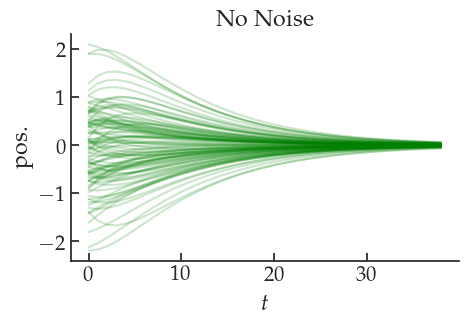

In [7]:
setup_plot()
for (pos, vel) in denoised_expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("No Noise")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [8]:
expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert)
    expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

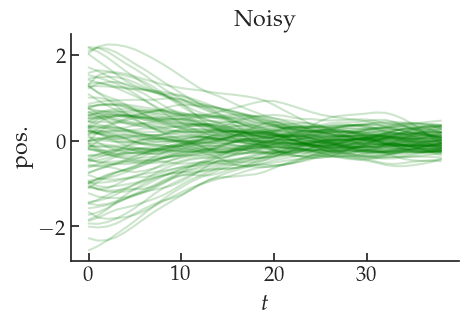

In [9]:
setup_plot()
for (pos, vel) in expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("Noisy")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [10]:
pi_BC = BC(expert_trajs, LinearModel(2, 1), lr=3e-4)
K_BC = [x.detach().numpy() for x in pi_BC.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_BC))

BC Data (3900, 2) (3900, 1)
Param. MSE = 0.9651278748447868


In [11]:
pi_DoubIL = DoubIL(expert_trajs, LinearModel(2, 1), src.lqg.dynamics, pi_BC=pi_BC, lr=3e-4)
K_DoubIL = [x.detach().numpy() for x in pi_DoubIL.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_DoubIL))

Done w/ BC
IV Data (3800, 2) (3800, 1)
Param. MSE = 0.14198622717178902


In [10]:
pi_ResiduIL = ResiduIL(expert_trajs, LinearModel(2, 1), LinearModel(2, 1), lr=3e-4)
K_ResiduIL = [x.detach().numpy() for x in pi_ResiduIL.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_ResiduIL))

Param. MSE = 0.2597352294524141


## LunarLander

In [16]:
from src.lunar_lander_env import LunarLanderContinuous
from src.lunar_lander_utils import T, dynamics, rollout, noisy_rollout, eval_policy

In [17]:
env = LunarLanderContinuous(confounding=False, fixed_terrain=True)

In [18]:
from stable_baselines3 import PPO
expert_net = PPO.load("src/experts/ll_expert")
def expert(s):
    return expert_net.predict(s, deterministic=True)[0]

In [19]:
env.reset()
denoised_expert_trajs = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    denoised_expert_trajs.append((s_traj, a_traj))
    Js.append(J)

In [63]:
env.reset()
expert_trajs2 = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    expert_trajs2.append((s_traj, a_traj))
    Js.append(J)

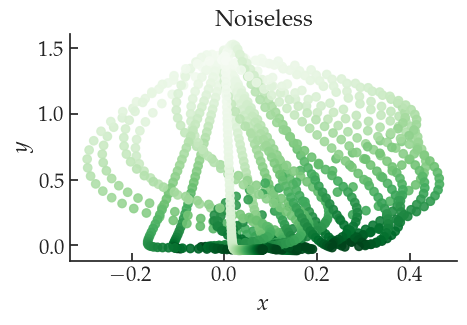

In [21]:
setup_plot()
for (s_traj, _) in denoised_expert_trajs:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noiseless")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

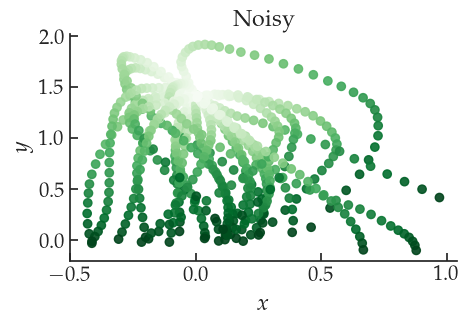

In [64]:
setup_plot()
for (s_traj, _) in expert_trajs2:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noisy")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

In [71]:
# Generate test set
# env.reset()
# denoised_test = []
# for _ in range(100):
#     s_traj, _, _ = rollout(lambda s: expert_net.predict(s, deterministic=True), env)
#     denoised_test.append((s_traj, expert(s_traj)))
# np.savez("data/denoised_test", denoised_test)

In [74]:
# env.reset()
# noisy_test = []
# for _ in range(100):
#     s_traj, _, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
#     noisy_test.append((s_traj, expert(s_traj)))
# np.savez("data/noisy_test", noisy_test)

In [46]:
# Generate training sets
# for i in range(5):
#     for size in [10, 20, 30, 40, 50]:
#         trajs = []
#         for _ in range(size):
#             s_traj, a_traj, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
#             trajs.append((s_traj, a_traj))
#         np.savez("data/train_{0}_{1}".format(size, i), trajs)

In [75]:
denoised_test = np.load("./data/denoised_test.npz", allow_pickle=True)["arr_0"]
noisy_test = np.load("./data/noisy_test.npz", allow_pickle=True)["arr_0"]

In [27]:
def mse(pi, dataset):
    total = 0
    for (s_traj, a_traj) in dataset:
        total += np.linalg.norm(pi(s_traj) - a_traj)
    return total / len(dataset)

In [164]:
# bc_mse_noisy = []
# bc_mse_denoised = []
# bc_J_noisy = []
# bc_J_denoised = []

doubil_mse_noisy = []
doubil_mse_denoised = []
doubil_J_noisy = []
doubil_J_denoised = []

# residuil_mse_noisy = []
# residuil_mse_denoised = []
# residuil_J_noisy = []
# residuil_J_denoised = []

In [ ]:
for i in range(5):
#     bc_mse_noisy_i = []
#     bc_mse_denoised_i = []
#     bc_J_noisy_i = []
#     bc_J_denoised_i = []

    doubil_mse_noisy_i = []
    doubil_mse_denoised_i = []
    doubil_J_noisy_i = []
    doubil_J_denoised_i = []

#     residuil_mse_noisy_i = []
#     residuil_mse_denoised_i = []
#     residuil_J_noisy_i = []
#     residuil_J_denoised_i = []
    
    for size in [10, 20, 30, 40, 50]:
        expert_trajs = np.load("./data/train_{0}_{1}.npz".format(size, i), allow_pickle=True)["arr_0"]
    
#         pi_BC = BC(expert_trajs, Model(env.observation_space.shape[0], env.action_space.shape[0]))
#         bc_mse_noisy_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
#         bc_mse_denoised_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
#         bc_J_noisy_i.append(eval_policy(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
#         bc_J_denoised_i.append(eval_policy(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
#         print('BC',
#               size,
#               bc_mse_noisy_i[-1],
#               bc_mse_denoised_i[-1],
#               bc_J_noisy_i[-1],
#               bc_J_denoised_i[-1])
        
        pi_DoubIL = DoubIL(denoised_expert_trajs,
                   Model(env.observation_space.shape[0], env.action_space.shape[0]),
                   dynamics)
        doubil_mse_noisy_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        doubil_mse_denoised_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        doubil_J_noisy_i.append(eval_policy(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
        doubil_J_denoised_i.append(eval_policy(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
        print('doubil',
              size,
              doubil_mse_noisy_i[-1],
              doubil_mse_denoised_i[-1],
              doubil_J_noisy_i[-1],
              doubil_J_denoised_i[-1])
        
#         pi_ResiduIL = ResiduIL(expert_trajs,
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]),
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]))
#         residuil_mse_noisy_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
#         residuil_mse_denoised_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
#         residuil_J_noisy_i.append(eval_policy(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
#         residuil_J_denoised_i.append(eval_policy(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
#         print('residuil',
#               size,
#               residuil_mse_noisy_i[-1],
#               residuil_mse_denoised_i[-1],
#               residuil_J_noisy_i[-1],
#               residuil_J_denoised_i[-1])
        
#     bc_mse_noisy.append(bc_mse_noisy_i)
#     bc_mse_denoised.append(bc_mse_denoised_i)
#     bc_J_noisy.append(bc_J_noisy_i)
#     bc_J_denoised.append(bc_J_denoised_i)
#     np.savez("data/bc_mse_noisy", bc_mse_noisy)
#     np.savez("data/bc_mse_denoised", bc_mse_denoised)
#     np.savez("data/bc_J_noisy", bc_J_noisy)
#     np.savez("data/bc_J_denoised", bc_J_denoised)
    
#     residuil_mse_noisy.append(residuil_mse_noisy_i)
#     residuil_mse_denoised.append(residuil_mse_denoised_i)
#     residuil_J_noisy.append(residuil_J_noisy_i)
#     residuil_J_denoised.append(residuil_J_denoised_i)
#     np.savez("data/residuil_mse_noisy", residuil_mse_noisy)
#     np.savez("data/residuil_mse_denoised", residuil_mse_denoised)
#     np.savez("data/residuil_J_noisy", residuil_J_noisy)
#     np.savez("data/residuil_J_denoised", residuil_J_denoised)

    doubil_mse_noisy.append(doubil_mse_noisy_i)
    doubil_mse_denoised.append(doubil_mse_denoised_i)
    doubil_J_noisy.append(doubil_J_noisy_i)
    doubil_J_denoised.append(doubil_J_denoised_i)
    np.savez("data/doubil_mse_noisy", doubil_mse_noisy)
    np.savez("data/doubil_mse_denoised", doubil_mse_denoised)
    np.savez("data/doubil_J_noisy", doubil_J_noisy)
    np.savez("data/doubil_J_denoised", doubil_J_denoised)

BC Data (6323, 6) (6323, 2)
